In [33]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import some_routines as sr

# 7. Building a quadtree

#### Download a file containing 1200 particle masses and positions, the data is in group /PartType4. Considering only the x and y coordinates of these particles (between 0 and 150), construct a quadtree with at most 12 particles per leaf node. You can treat the masses and positions as dimensionless and use G=1. You are free to use the where function and/or masks. Plot the particles and indicate which particles are in which node. Calculate the n=0 multipole moment for the leaf node containing the particle with index i=100 and that of all of its parent nodes up to and including the root node.

In [34]:
import h5py # Hopefully h5py is on the pczaal computers
fname = 'colliding.hdf5'
f = h5py.File(fname, 'r')

# Particles we are interested in
positions = f['PartType4/Coordinates'][:]
# Only consider x and y coordinates
positions = positions[:,:2] # shape (1200,2)

The setup of the Quad Tree implementation in Python uses three classes: \textit{Point}, \textit{Node} and \textit{QuadTree}. This setup is inspired from the following blogpost: \url{https://kpully.github.io/Quadtrees/}.

The \textit{Point} is simply a class that has the x and y position of the points. The \textit{Node} is a class that contains points and may contain (4) children (also nodes). The \textit{QuadTree} class then contains the points and nodes, and a method to subdivide the rootnode, which contains all points, into multiple nodes which contain only some threshold amount of points.

In [35]:
# Create 3 classes, Point, Node and QuadTree
# The QuadTree starts with a rootnode, which starts with all points
# Subdivide a node when threshold amount of points is met

# This setup is inspired from the following blogpost:
# https://kpully.github.io/Quadtrees/. 

class Point():
    """
    Holds positions of particles
    """
    def __init__(self, x, y):
        self.x = x
        self.y = y
class Node():
    """ 
    Every node defines a box in 2D.
    The box is defined from the lower left corner x0,y0 with a 
    certain width and height. 
    
    Every node contains points. Some nodes contain children.
    Every node also has a multipole, calculated with def calc_multipole()
    """
    def __init__(self, x0,y0, width, height, points):
        # Origin of the node
        self.x0 = x0
        self.y0 = y0

        self.width = width
        self.height = height

        # Points inside the node
        self.points = points
        # Children of the node
        self.chil = []
        # Multipole of the node
        self.multipole = 0
    
class QuadTree():
    """
    The QuadTree holds the nodes. It starts with a rootnode that holds
    all the points. The method .subdivide() recursively subdivides
    the rootnode into four children until a threshold amount of points
    is reached per node. 
    
    positions -- (n,2) array containing the positions of n particles
    rnorigin  -- (2,)  array containing the origin of the rootnode
    rnwidth   --       float with the width of the rootnode box
    rnheight  --       float with the heigh of the rootnode box
                -> These two params should confine all particles
    thresh    --       int   maximum amount of particles in a node
    """
    def __init__(self, positions, rnorigin, rnwidth, rnheight, thresh=1):
        # threshold for division
        self.thresh = thresh
        self.points = [Point(*pos) for pos in positions]
        self.rootnode = Node(*rnorigin,rnwidth,rnheight,self.points)
        
    def addpoint(self, x,y):
        self.points.append(Point(x,y))
        
    def get_points(self):
        return self.points
    
    def subdivide(self):
        """Subdivide the whole tree down to the threshold"""
        recsubdivide(self.rootnode, self.thresh)
        
    def get_numnodes(self):
        """Return the total number of nodes"""
        return len(find_chil(self.rootnode))
        
    def plotQTree(self, positions, save=None, show=False):
        # Find all nodes in the whole graph
        all_nodes = find_chil(self.rootnode)
        
        fig, ax = plt.subplots(figsize=(10, 8))
        for node in all_nodes:
            # Plot a rectangle defining the box
            box = patches.Rectangle((node.x0, node.y0)
                            , node.width, node.height, fill=False)
            ax.add_patch(box)
            
        plt.scatter(positions[:,0], positions[:,1], s=7)
        plt.ylabel('y')
        plt.xlabel('x')
        if save is not None:
            plt.savefig(save)
        if show: plt.show()
        plt.close()
        
        
def findpoints(x, y, width, height, points):
    """
    Return the points in 'points' that are contained within the dimensions
    (x,x+width) (y,y+width)
    """
    containedpnts = []
    for point in points:
        if point.x >= x and point.x <= x+width and \
           point.y >= y and point.y <= y+height:
            containedpnts.append(point)
    return containedpnts


def recsubdivide(node, thresh):
    """
    Recursively subdivide a node until it contains <= thresh points
    """
    
    # Stop when node contains threshold amount of points
    if len(node.points) <= thresh:
        return 
    
    # Subdivide both dimensions
    wnew = node.width/2
    hnew = node.height/2
    
    # Find points that are in lower left box of the subdivision
    pnts = findpoints(node.x0, node.y0, wnew, hnew, node.points)
    # Create the new node that has these points
    node1 = Node(node.x0, node.y0, wnew, hnew, pnts)
    # Also subdivide this node
    recsubdivide(node1, thresh)
    
    # Repeat for the other 3 nodes.
    pnts = findpoints(node.x0, node.y0+hnew, wnew, hnew, node.points)
    node2 = Node(node.x0, node.y0+hnew, wnew, hnew, pnts)
    recsubdivide(node2, thresh)
    
    pnts = findpoints(node.x0+wnew, node.y0, wnew, hnew, node.points)
    node3 = Node(node.x0+wnew, node.y0, wnew, hnew, pnts)
    recsubdivide(node3, thresh)
    
    pnts = findpoints(node.x0+wnew, node.y0+hnew, wnew, hnew, node.points)
    node4 = Node(node.x0+wnew, node.y0+hnew, wnew, hnew, pnts)
    recsubdivide(node4, thresh)
    
    # Keep track of the children
    node.chil = [node1, node2, node3, node4]
    
    
def find_chil(node):
    """
    Find all children of a node, recursive function.
    """
    if not node.chil:
        # return the node itself
        return [node]
    else:
        all_children = []
        for child in node.chil:
            # Append also the children of the children
            all_children += find_chil(child)
        return all_children
    
def calc_multipoles(node):
    """
    Recursive function. Assign the n=0 multipole of a node 
    and of all it's children. Does not return anything.
    Run with the rootnode to calculate all multipoles.

    The multipole of a node is the sum of the multipoles of its children
    The n=0 multipole of a leafnode is the sum of the particle masses
    In this case m=1, thus it is simply the number of particles
    """
    if not node.chil:
        # Leaf node, multipole is the number of particles
        node.multipole = len(node.points)
    else:
        for child in node.chil:
            # Multipole is the sum of the children
            calc_multipoles(child)
            node.multipole += child.multipole
    return

def findpoint(node, point):
    """
    Find the leaf node that contains the point 'point'
    Call this function with the rootnode of the Quad Tree.
    It recursively checks which node of the children contains 
    the point 'point'
    
    Returns
    node    -- Node  -- The Node class that contains the point
    parents -- list  -- all parents, starting from the root node
    
    """
    if not node.chil:
        # This node contains the point, the child is not a parent
        return node, []
    else:
        parents = [node]
        # Check which child contains the point
        if point[0] > node.x0+node.width/2:
            # right half
            child = [2,3] #lower,upper
        else:
            # left half
            child = [0,1] # lower,upper
        if point[1] > node.y0+node.height/2:
            # upper half
            child = child[1]
        else:
            # lower half
            child = child[0]

        # Pursue this child, and save its parents
        node, childparent = findpoint(node.chil[child], point)
        parents += childparent
        
        return node, parents    

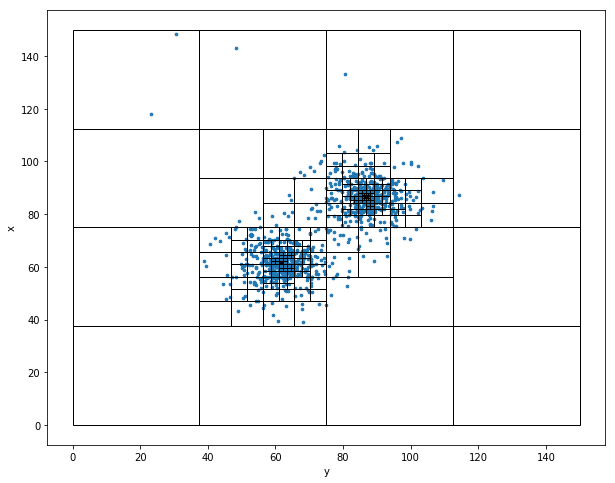

In [36]:
rnorigin = [0,0] # root node origin
rnwidth = 150 # root node width (of the box)
rnheight = 150 # root node height (of the box)

# Initialize the QuadTree
QT = QuadTree(positions, rnorigin, rnwidth, rnheight, 12)
# Subdivide
QT.subdivide()
# Plot result
QT.plotQTree(positions, save='./plots/q7_1.png', show=True)

#### Calculate the $n=0$ multipole moment of each leaf and then recursively for each node in the tree. 

In [37]:
# Assign the multipole to each node recursively
calc_multipoles(QT.rootnode)

####  Print the $n = 0$ multipole moment for the leaf node containing the particle with index $i = 100$ and that of all its parent nodes up to and including the root node.

In [38]:
# Find the node containing particle with index 100 and all its parents
nodepoint, parents = findpoint(QT.rootnode, positions[100])

# Print the n=0 multipole moment for the leaf node containing particle
# with index = 100 and that of all of its parents up to and including
# the root node
print ("Multipole moment of the Node containing the point:")
print (nodepoint.multipole)
print ("Multipole moment of its parents, up to and including the root node:")
for node in reversed(parents):
    print (node.multipole)

Multipole moment of the Node containing the point:
10
Multipole moment of its parents, up to and including the root node:
17
23
573
573
1200


Parent nodes:
0 150
0 75.0
37.5 37.5
37.5 18.75
46.875 9.375
Node containing the point:
51.5625 4.6875


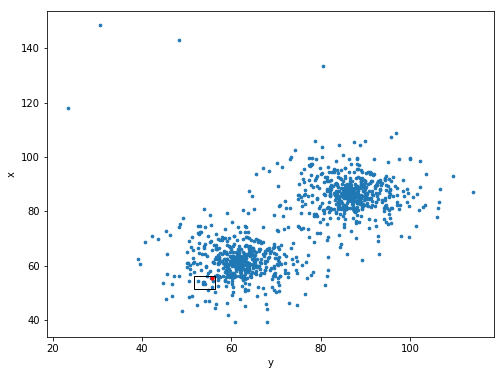

In [39]:
# TEST CELL TO VERIFY THAT IT WORKS
print ("Parent nodes:")
for node in parents:
    print (node.x0,node.width)
print ("Node containing the point:")
print (nodepoint.x0,nodepoint.width)
    
fig, ax = plt.subplots(figsize=(8,6))
node = nodepoint
# Plot a rectangle defining the box
box = patches.Rectangle((node.x0, node.y0)
                , node.width, node.height, fill=False)
ax.add_patch(box)

plt.scatter(positions[:,0], positions[:,1], s=7)
plt.scatter(positions[100,0], positions[100,1], s=10,c='r')
plt.ylabel('x')
plt.xlabel('y')
plt.show()
